## Assignment No. 7

## `Name and PRN:`
### - `Name:` Harsh Naik
### - `PRN :` 230340128013

In [53]:
###-----------------
### Import Libraries
###-----------------
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd

In [54]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input1' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = '../models' # location to save model files
valDir = 'valid_flowers' # location related to this dataset
altName = 'students_base_flowers' # Model file name for this alternative

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 100   # number of cycles to run
ALPHA = 0.001
BATCH_SIZE = 32
TEST_SIZE = 0.2
IMG_HEIGHT = 190
IMG_WIDTH = 190

# Transformations
# flipping
FLIP_MODE = "horizontal_and_vertical"
# Rotation
ROTATION_FACTOR = (-0.1, 0.1) 
# filling mode
FILL_MODE = 'nearest'


## Early Stopping
ES_PATIENCE = 20 # if performance does not improve stop
# Learning rates
LR_PATIENCE = 10 # if performace is not improving reduce alpha
LR_FACTOR = 0.5 # rate of reduction of alpha


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,8),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Basic Hygiene

In [55]:
###------------------
### Memory Management
###------------------

physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print (physical_devices)
else:
    print ('Error: No GPU device found')

Error: No GPU device found


## Helper Functions
**Note** all helper functions have been moved to util.helper

## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [56]:
'''
    For reading from web link
'''

#import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                   fname='flower_photos',
#                                   untar=True)
#data_dir = pathlib.Path(data_dir)
'''
    For reading from local directory
'''
data_dir = os.path.join(inpDir, subDir)

In [57]:
data_dir

'../input1/flower_photos'

In [58]:
# list content of data_dir
os.listdir(data_dir)

['sunflowers', 'LICENSE.txt', 'roses', 'daisy', 'dandelion', 'tulips']

In [59]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to printclass_names.values()
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [60]:
def fn_plot_label(train_df, test_df):
    
    plt.figure(figsize = (15,5))
    
    plt.subplot(1,2,1)

    ax = train_df['label'].value_counts().plot(kind='bar',
                                               title="Training distribution",
                                               color = 'DarkBlue', alpha = 0.8)


    plt.subplot(1,2,2)
    
    ax = test_df['label'].value_counts().plot(kind='bar',
                                              title="Testing distribution",
                                              color = 'Orange', alpha = 0.8)

In [61]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='training',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Is it picking the class names?

In [62]:
class_names = train_ds.class_names
num_classes = len(class_names)
print('total ', num_classes, class_names)

total  5 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Verify the data

To verify that the dataset looks correct, let's plot the first batch from the training set and display the class name below each image.


2023-06-14 15:35:20.403436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]
2023-06-14 15:35:20.403844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2936]
	 [[{{node Placeholder/_0}}]]


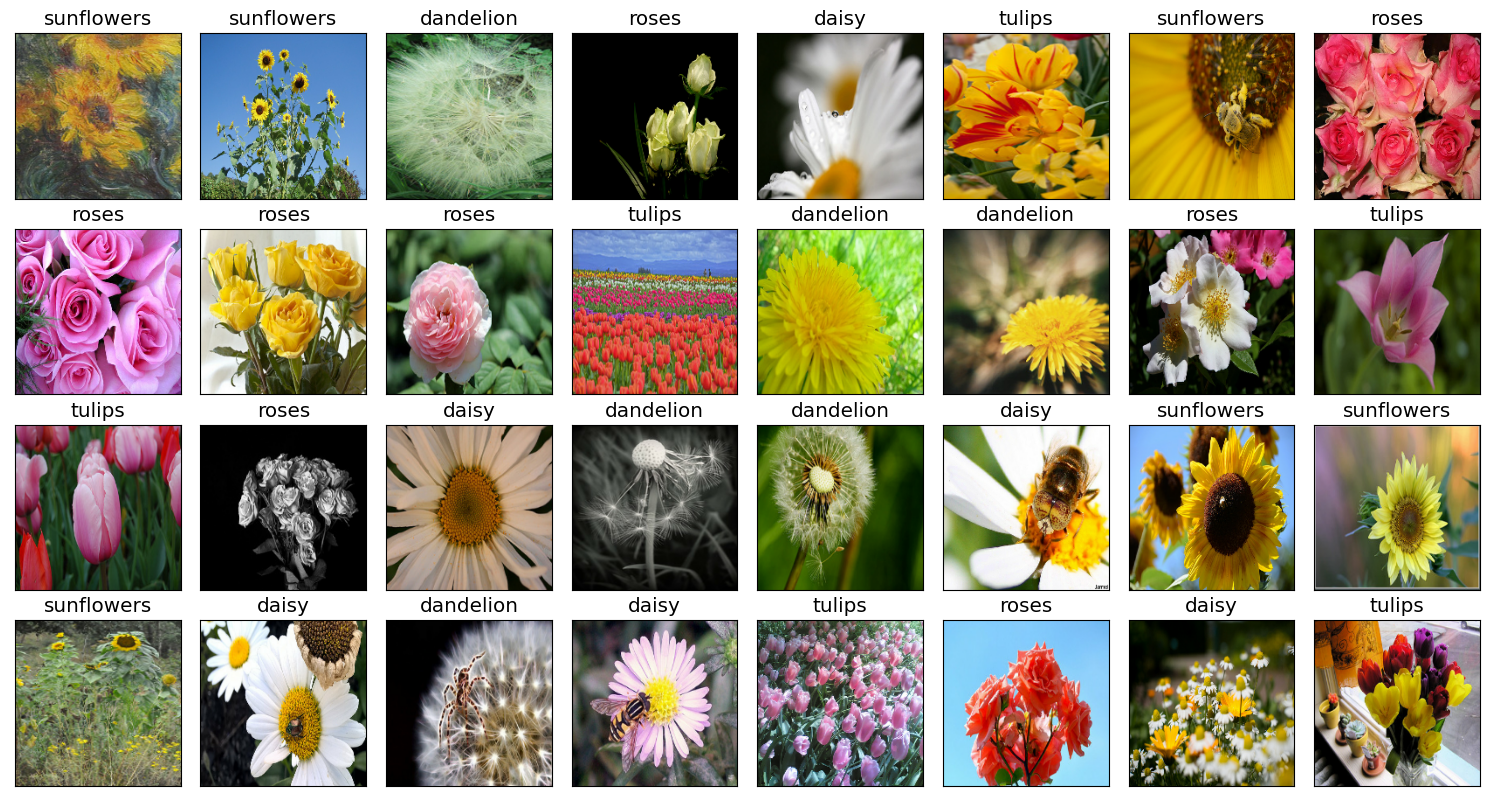

In [63]:
# set figure size
fig = plt.figure()  # figure size in inches with default params

# Adjust the subplot layout parameters.
fig.subplots_adjust(left=0., # as a fraction of the figure width
                    right=1., # use full width, as a fraction of the figure width
                    bottom=0., # as a fraction of the figure height
                    top=1., # as a fraction of the figure height
                    hspace=0.05, # as a fraction of the average Axes height
                    wspace=0.05) # width of the padding between subplots

# take one batch of the dataset
for images, labels in train_ds.take(1):
    
    # iterate through the batch
    for i in range(BATCH_SIZE):
        
        # add a subplot
        ax = fig.add_subplot( BATCH_SIZE//8, 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure
        
        # image_size may have converted these images to float
        ax.imshow(images[i].numpy().astype("uint8")) 
        
        # display class in the title
        ax.set_title(class_names[labels[i]])
        
# fit the subplot(s) in to the figure area
plt.tight_layout()
    
# display all open images    
plt.show()

## Build Model


In [66]:
# kernel (weight initialization)
krnl_init = tf.keras.initializers.GlorotUniform( seed = RANDOM_STATE)

model = tf.keras.models.Sequential()

model.add( tf.keras.layers.Rescaling(1./255))

model.add(tf.keras.layers.RandomRotation(ROTATION_FACTOR,fill_mode=FILL_MODE,seed=RANDOM_STATE))
model.add(tf.keras.layers.RandomFlip(mode=FLIP_MODE,seed=RANDOM_STATE))

# Convolution 1
model.add(tf.keras.layers.Conv2D(32, (3, 3), # number of filters and filter size
                                 kernel_initializer = krnl_init,
                                 padding='same', 
                                 activation='relu',
                                 input_shape=(190, 190, 1))) # (188 x 188 x 32)
# Pool 1
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # (94 x 94 x 32)

# Convolution 2
model.add(tf.keras.layers.Conv2D(64, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation='relu')) # (92 x 92 x 64)

# Pool 2
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # ( 46 x 46 x 64)

# Convolution 3
model.add(tf.keras.layers.Conv2D(128, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation = 'relu' ) ) # ( 44 x 44 x 128)
# Pool 3
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # ( 22 x 22 x 128)

# Convolution 4
model.add(tf.keras.layers.Conv2D(256, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation = 'relu' ) ) # ( 20 x 20 x 256)
# Pool 4
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # ( 10 x 10 x 256)

# Convolution 5
model.add(tf.keras.layers.Conv2D(512, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation = 'relu' ) ) # ( 8 x 8 x 512)
# Pool 5
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # ( 4 x 4 x 512)

# Convolution 6
model.add(tf.keras.layers.Conv2D(1024, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation = 'relu' ) ) # ( 2 x 2 x 1024)

#flatten layers
model.add(tf.keras.layers.Flatten())

# Dense 1
model.add(tf.keras.layers.Dense(512,
                                kernel_initializer = krnl_init,
                                activation='relu'))
# Dense 2
model.add(tf.keras.layers.Dense(128,
                                kernel_initializer = krnl_init,
                                activation='relu'))
# Dense 3
model.add(tf.keras.layers.Dense(64,
                                kernel_initializer = krnl_init,
                                activation='relu'))

# Dense 4
model.add(tf.keras.layers.Dense(5))

### Compile and train the model

In [67]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),              
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=test_ds,epochs=EPOCHS,
                    batch_size=BATCH_SIZE)
#                     callbacks = [early_callback, model_callback,lr_callback])

Epoch 1/100


2023-06-14 15:35:53.274888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2936]
	 [[{{node Placeholder/_0}}]]
2023-06-14 15:35:53.275257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]


92/92 [==============================] - ETA: 0s - loss: 1.4513 - accuracy: 0.3185

2023-06-14 15:36:49.844857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [734]
	 [[{{node Placeholder/_4}}]]
2023-06-14 15:36:49.845235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [734]
	 [[{{node Placeholder/_4}}]]


92/92 [==============================] - 62s 651ms/step - loss: 1.4513 - accuracy: 0.3185 - val_loss: 1.3780 - val_accuracy: 0.3856
Epoch 2/100
92/92 [==============================] - 60s 647ms/step - loss: 1.2516 - accuracy: 0.4363 - val_loss: 1.2186 - val_accuracy: 0.4564
Epoch 3/100
92/92 [==============================] - 59s 640ms/step - loss: 1.1383 - accuracy: 0.4877 - val_loss: 1.1284 - val_accuracy: 0.5136
Epoch 4/100
92/92 [==============================] - 59s 638ms/step - loss: 1.0788 - accuracy: 0.5303 - val_loss: 1.0463 - val_accuracy: 0.5490
Epoch 5/100
92/92 [==============================] - 59s 640ms/step - loss: 1.0390 - accuracy: 0.5664 - val_loss: 1.0520 - val_accuracy: 0.5749
Epoch 6/100
92/92 [==============================] - 59s 641ms/step - loss: 0.9923 - accuracy: 0.5869 - val_loss: 1.0050 - val_accuracy: 0.6076
Epoch 7/100
92/92 [==============================] - 59s 639ms/step - loss: 0.9197 - accuracy: 0.6304 - val_loss: 0.9257 - val_accuracy: 0.6240
Epoc

In [68]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 190, 190, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 190, 190, 3)      0         
 tation)                                                         
                                                                 
 random_flip_3 (RandomFlip)  (None, 190, 190, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 190, 190, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 95, 95, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 93, 93, 64)       

In [69]:
res_df = pd.DataFrame(history.history)
res_df.head()

loss  accuracy  val_loss  val_accuracy
0  1.451262  0.318460  1.378045      0.385559
1  1.251604  0.436308  1.218574      0.456403
2  1.138317  0.487738  1.128408      0.513624
3  1.078818  0.530313  1.046280      0.549046
4  1.039037  0.566417  1.052019      0.574932

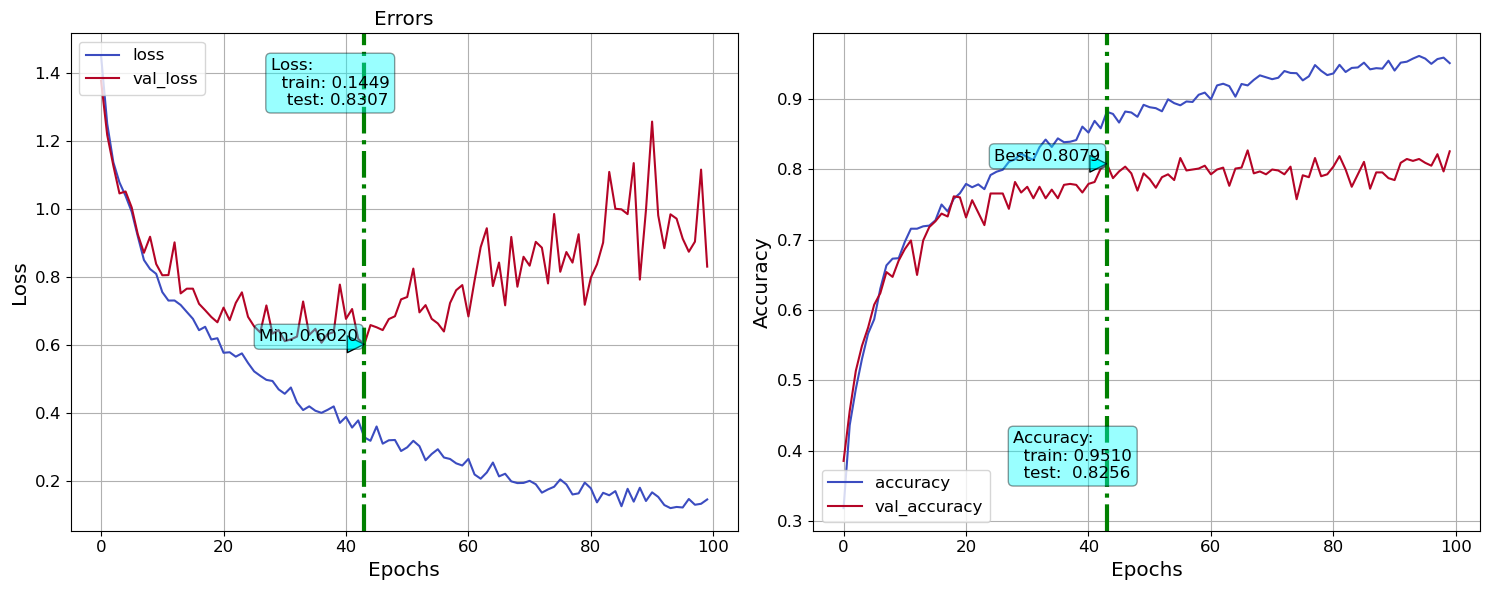

In [70]:
fn_plot_tf_hist(res_df)

## Using dropouts


In [71]:
#dropout rate
dor1 = 0.1
dor2 = 0.15
dor3 = 0.2
dor4 = 0.25
dor5 = 0.3
dor6 = 0.35
dor7 = 0.45
dor8 = 0.5

# kernel (weight initialization)
krnl_init = tf.keras.initializers.GlorotUniform( seed = RANDOM_STATE)

model = tf.keras.models.Sequential()

model.add( tf.keras.layers.Rescaling(1./255))

model.add(tf.keras.layers.RandomRotation(ROTATION_FACTOR,fill_mode=FILL_MODE,seed=RANDOM_STATE))
model.add(tf.keras.layers.RandomFlip(mode=FLIP_MODE,seed=RANDOM_STATE))

# Convolution 1
model.add(tf.keras.layers.Conv2D(32, (3, 3), # number of filters and filter size
                                 kernel_initializer = krnl_init,
                                 padding='same', 
                                 activation='relu',
                                 input_shape=(190, 190, 1))) # (188 x 188 x 32)
# Pool 1
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # (94 x 94 x 32)

# dropout 1
tf.keras.layers.Dropout(rate=dor1,seed=RANDOM_STATE)

# Convolution 2
model.add(tf.keras.layers.Conv2D(64, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation='relu')) # (92 x 92 x 64)

# Pool 2
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # ( 46 x 46 x 64)

# dropout 2
tf.keras.layers.Dropout(rate=dor2,seed=RANDOM_STATE)

# Convolution 3
model.add(tf.keras.layers.Conv2D(128, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation = 'relu' ) ) # ( 44 x 44 x 128)
# Pool 3
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # ( 22 x 22 x 128)

# dropout 3
tf.keras.layers.Dropout(rate=dor3,seed=RANDOM_STATE)

# Convolution 4
model.add(tf.keras.layers.Conv2D(256, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation = 'relu' ) ) # ( 20 x 20 x 256)
# Pool 4
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # ( 10 x 10 x 256)

# dropout 4
tf.keras.layers.Dropout(rate=dor4,seed=RANDOM_STATE)

# Convolution 5
model.add(tf.keras.layers.Conv2D(512, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation = 'relu' ) ) # ( 8 x 8 x 512)
# Pool 5
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # ( 4 x 4 x 512)

# dropout 5
tf.keras.layers.Dropout(rate=dor5,seed=RANDOM_STATE)

# Convolution 6
model.add(tf.keras.layers.Conv2D(1024, (3, 3),
                                 kernel_initializer = krnl_init,
                                 activation = 'relu' ) ) # ( 2 x 2 x 1024)


#flatten layers
model.add(tf.keras.layers.Flatten())

# Dense 1
model.add(tf.keras.layers.Dense(512,
                                kernel_initializer = krnl_init,
                                activation='relu'))

# dropout 6
tf.keras.layers.Dropout(rate=dor6,seed=RANDOM_STATE)

# Dense 2
model.add(tf.keras.layers.Dense(128,
                                kernel_initializer = krnl_init,
                                activation='relu'))
# dropout 7
tf.keras.layers.Dropout(rate=dor7,seed=RANDOM_STATE)

# Dense 3
model.add(tf.keras.layers.Dense(64,
                                kernel_initializer = krnl_init,
                                activation='relu'))

# dropout 8
tf.keras.layers.Dropout(rate=dor8,seed=RANDOM_STATE)

# Dense 4
model.add(tf.keras.layers.Dense(5))

### Compile and train the model

In [72]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),              
              metrics=['accuracy'])

history = model.fit(train_ds,
                    validation_data=test_ds,epochs=EPOCHS,
                    batch_size=BATCH_SIZE)
#                     callbacks = [early_callback, model_callback,lr_callback])

Epoch 1/100
92/92 [==============================] - 61s 645ms/step - loss: 1.5509 - accuracy: 0.2650 - val_loss: 1.4621 - val_accuracy: 0.2970
Epoch 2/100
92/92 [==============================] - 59s 639ms/step - loss: 1.3189 - accuracy: 0.4172 - val_loss: 1.2589 - val_accuracy: 0.4319
Epoch 3/100
92/92 [==============================] - 59s 639ms/step - loss: 1.1732 - accuracy: 0.4986 - val_loss: 1.1061 - val_accuracy: 0.5395
Epoch 4/100
92/92 [==============================] - 59s 637ms/step - loss: 1.0526 - accuracy: 0.5542 - val_loss: 1.2640 - val_accuracy: 0.5191
Epoch 5/100
92/92 [==============================] - 59s 638ms/step - loss: 1.0499 - accuracy: 0.5722 - val_loss: 1.1199 - val_accuracy: 0.5300
Epoch 6/100
92/92 [==============================] - 59s 636ms/step - loss: 1.0091 - accuracy: 0.5998 - val_loss: 1.0239 - val_accuracy: 0.5886
Epoch 7/100
92/92 [==============================] - 59s 639ms/step - loss: 0.9304 - accuracy: 0.6308 - val_loss: 0.9363 - val_accuracy:

In [73]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 190, 190, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 190, 190, 3)      0         
 tation)                                                         
                                                                 
 random_flip_4 (RandomFlip)  (None, 190, 190, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 190, 190, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 95, 95, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 93, 93, 64)       

In [74]:
res_df = pd.DataFrame(history.history)
res_df.head()

loss  accuracy  val_loss  val_accuracy
0  1.550864  0.264986  1.462095      0.297003
1  1.318937  0.417234  1.258886      0.431880
2  1.173159  0.498638  1.106096      0.539510
3  1.052648  0.554155  1.263991      0.519074
4  1.049930  0.572207  1.119853      0.529973

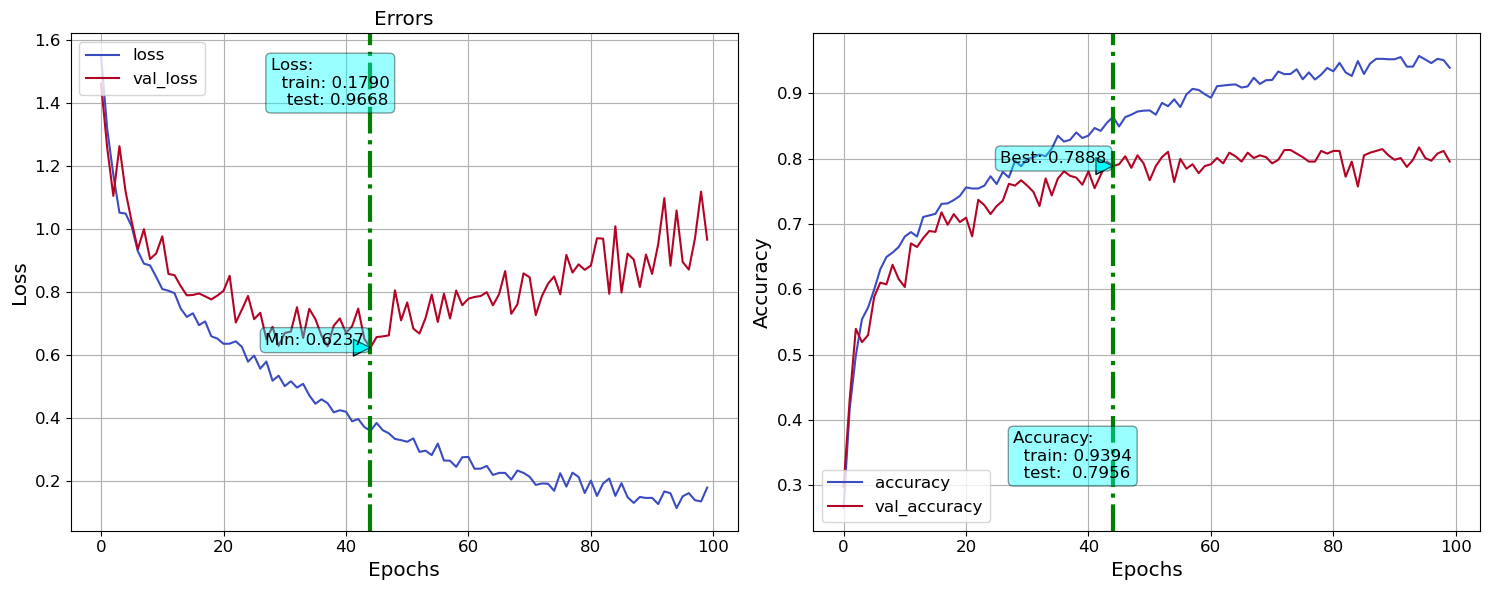

In [75]:
fn_plot_tf_hist(res_df)

## Results after tuning hyperparameters and building various models

## $$ ******************************************* $$

## Curve after vannila Model:
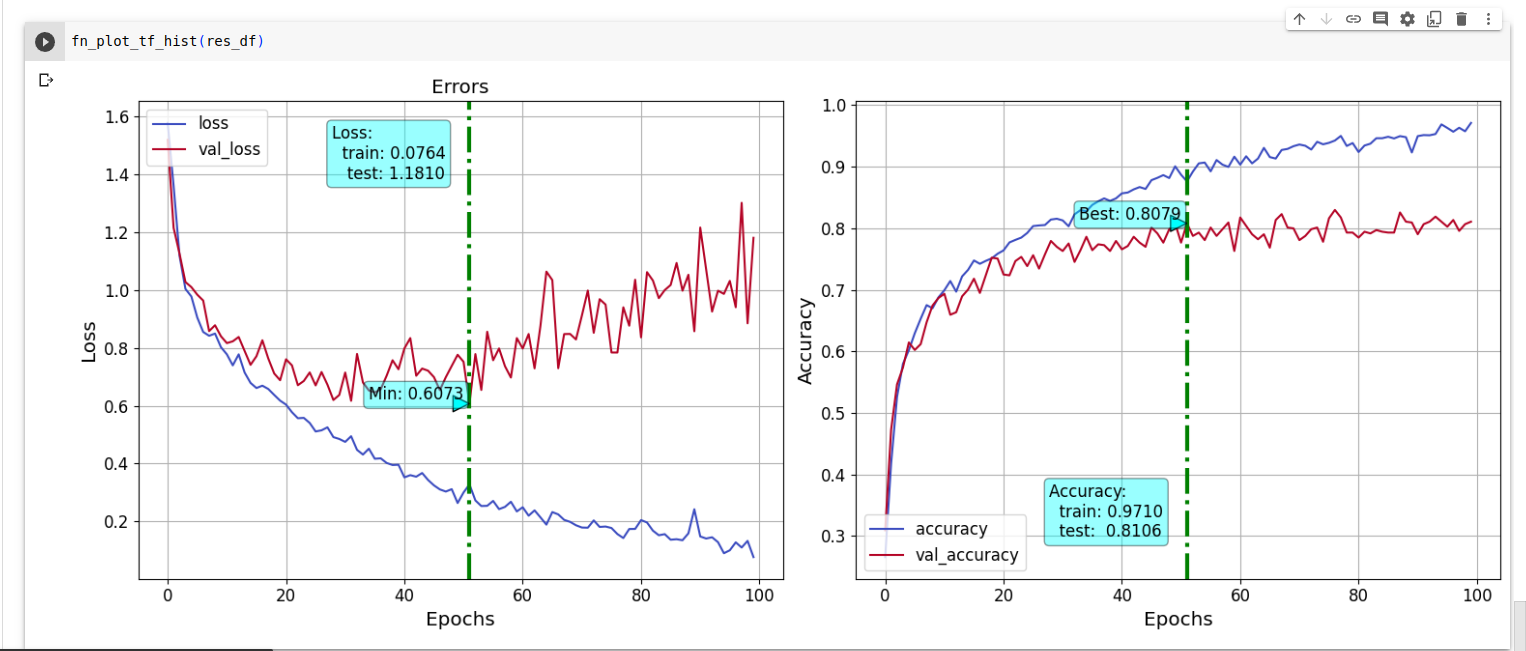

## $$ ******************************************* $$

## Using Dropout 
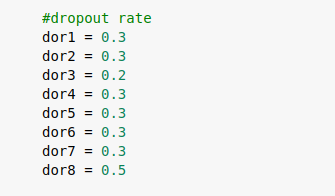

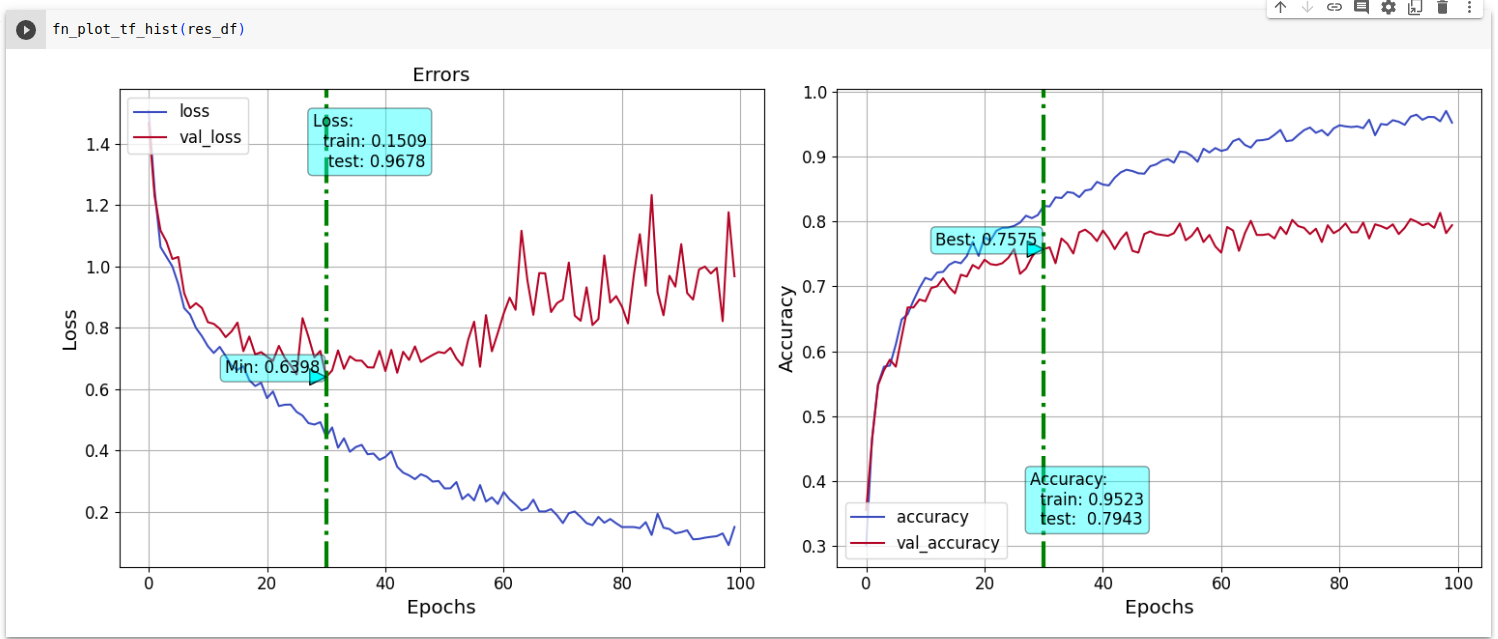

## $$ ******************************************* $$

## using batch Normalization
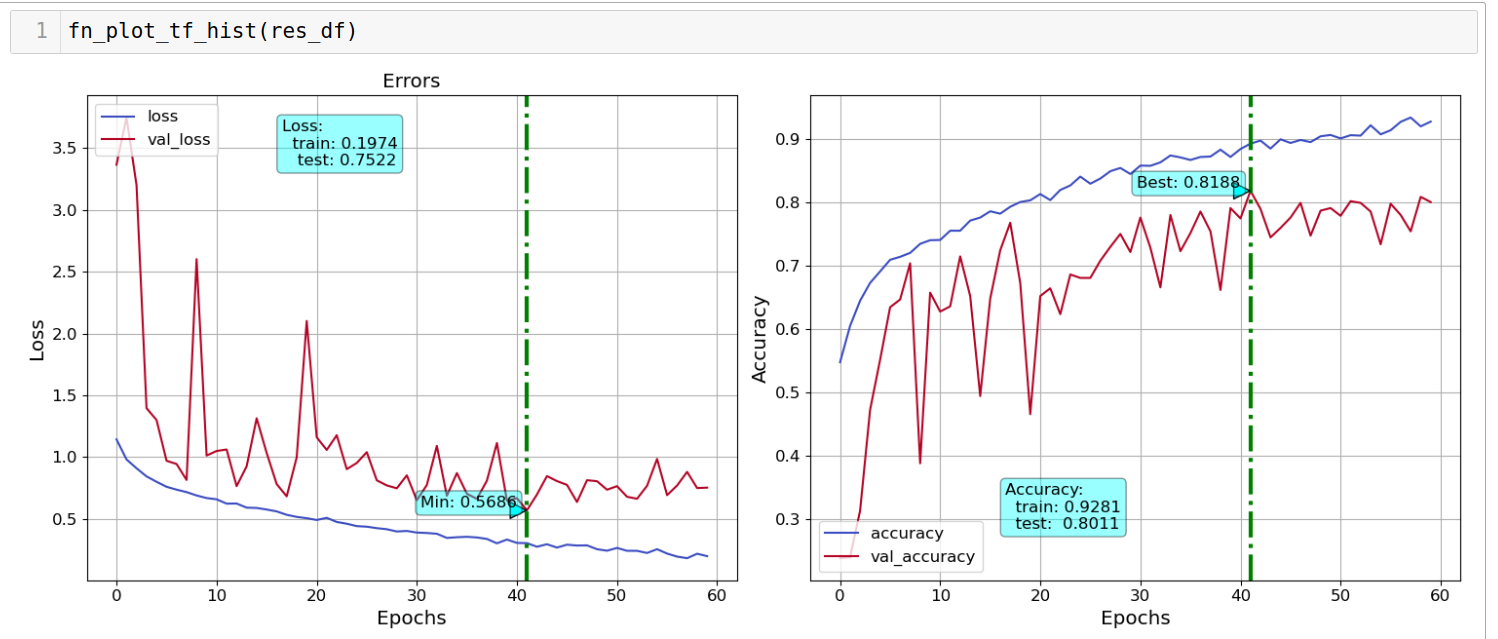

## $$ ******************************************* $$

## using 3 Dense layer and dropouts
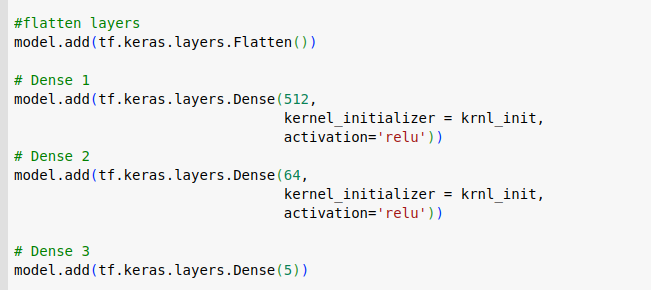


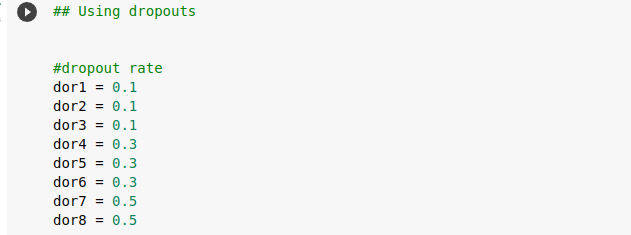
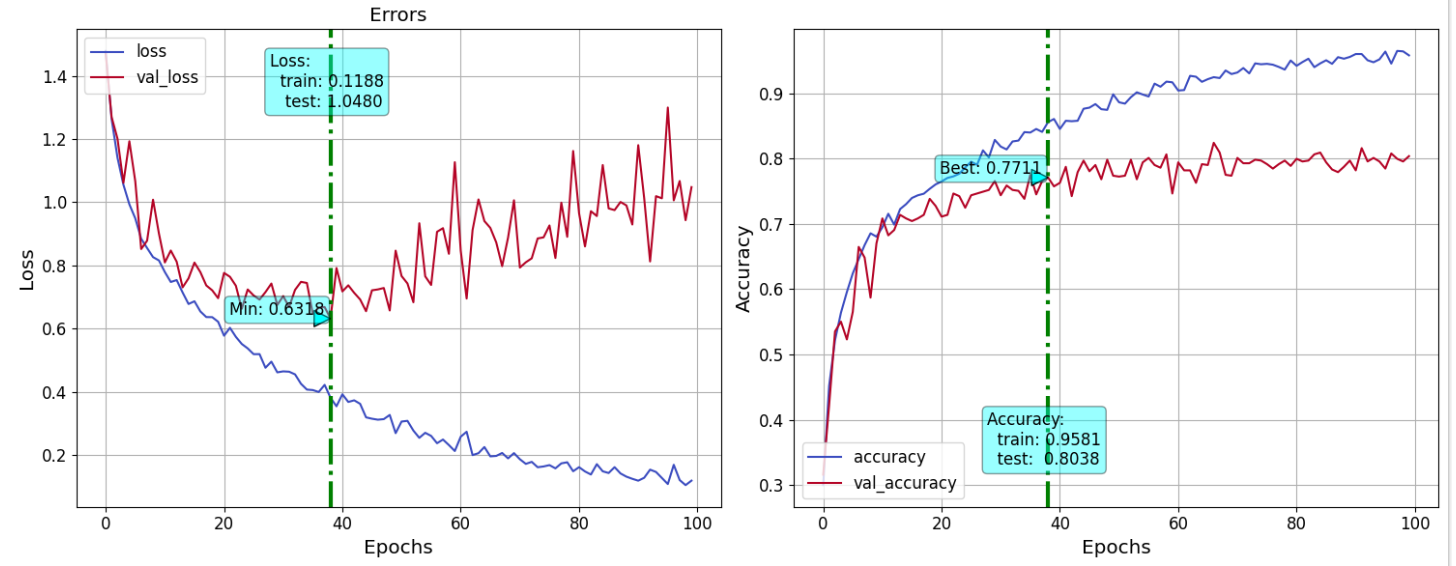

## $$ ******************************************* $$

# dropout, batch normalization, padding= same, softmax


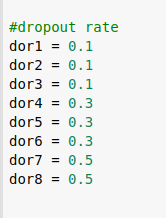
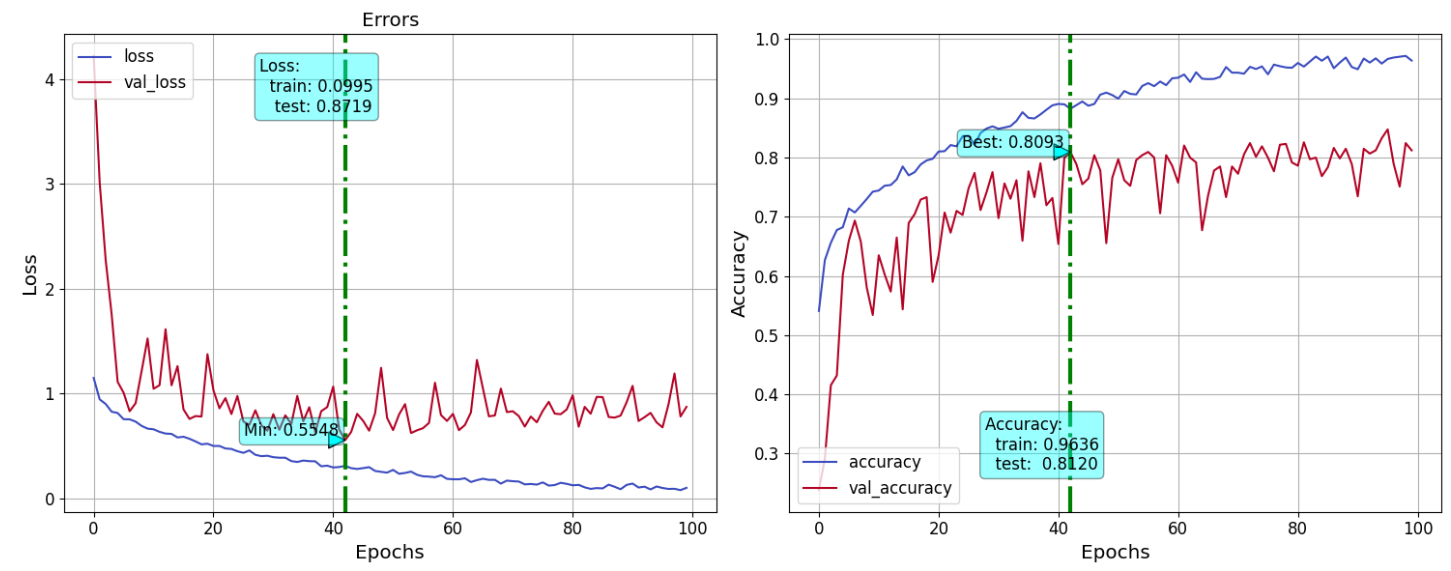

## $$ ******************************************* $$

# Different dropout rates
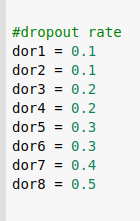
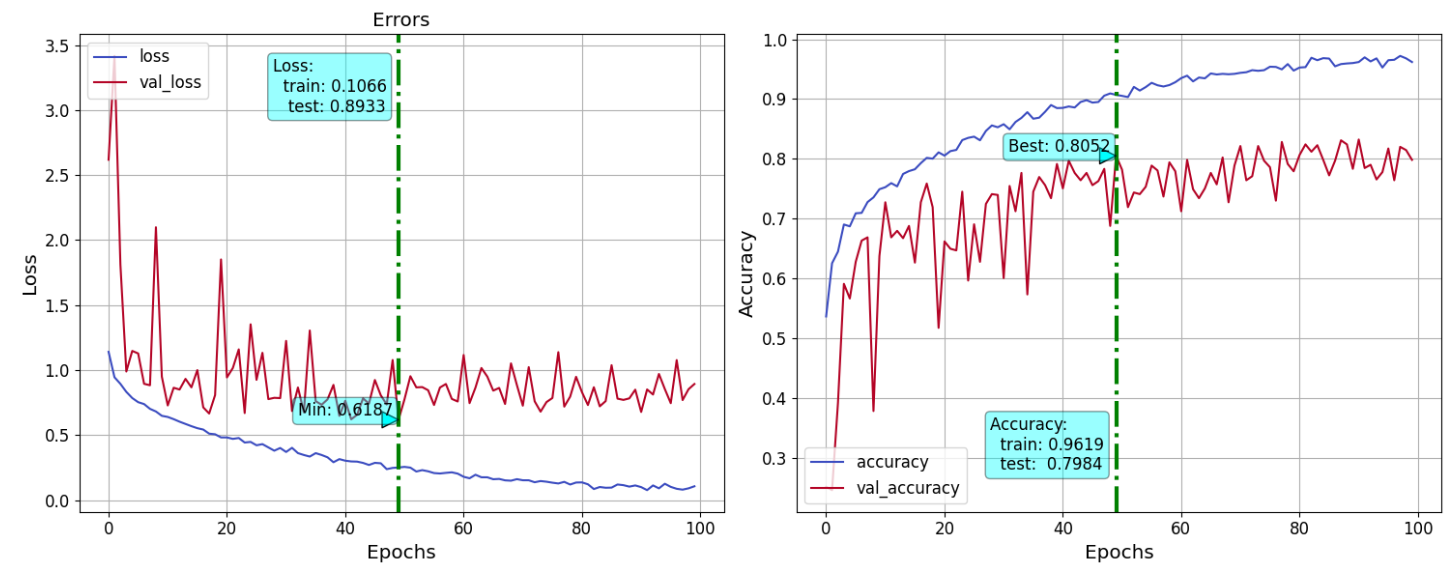

## $$ ******************************************* $$

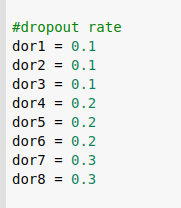
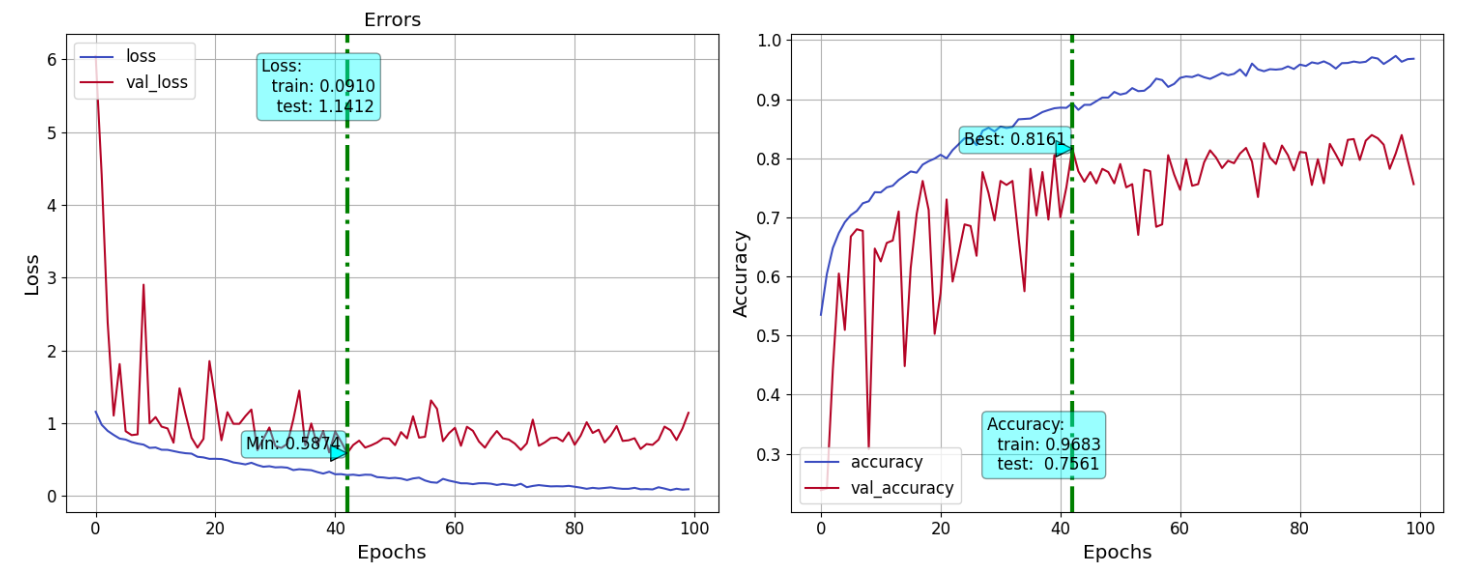

## $$ ******************************************* $$

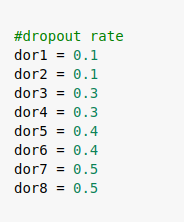
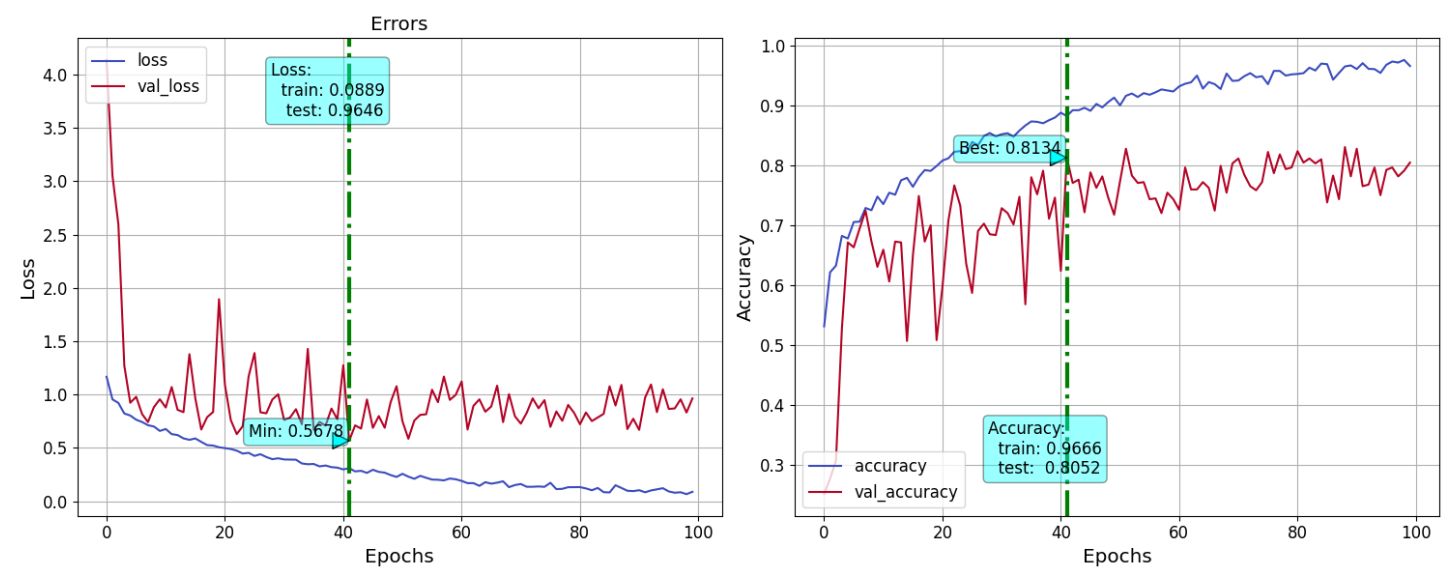